In [17]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [18]:
print("Number GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print(tf.test.is_built_with_cuda())

Number GPUs Available:  1
True


In [19]:

num_skipped = 0
for folder_name in ("Cat", "Dog"):
    folder_path = os.path.join("kagglecatsanddogs_3367a\\PetImages", folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)

print("Deleted %d images" % num_skipped)

Deleted 0 images


In [20]:
image_size = (180, 180)
batch_size = 32

train_ds, val_ds = tf.keras.utils.image_dataset_from_directory(
    "kagglecatsanddogs_3367a\\PetImages",
    validation_split=0.2,
    subset="both",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 23421 files belonging to 2 classes.
Using 18737 files for training.
Using 4684 files for validation.


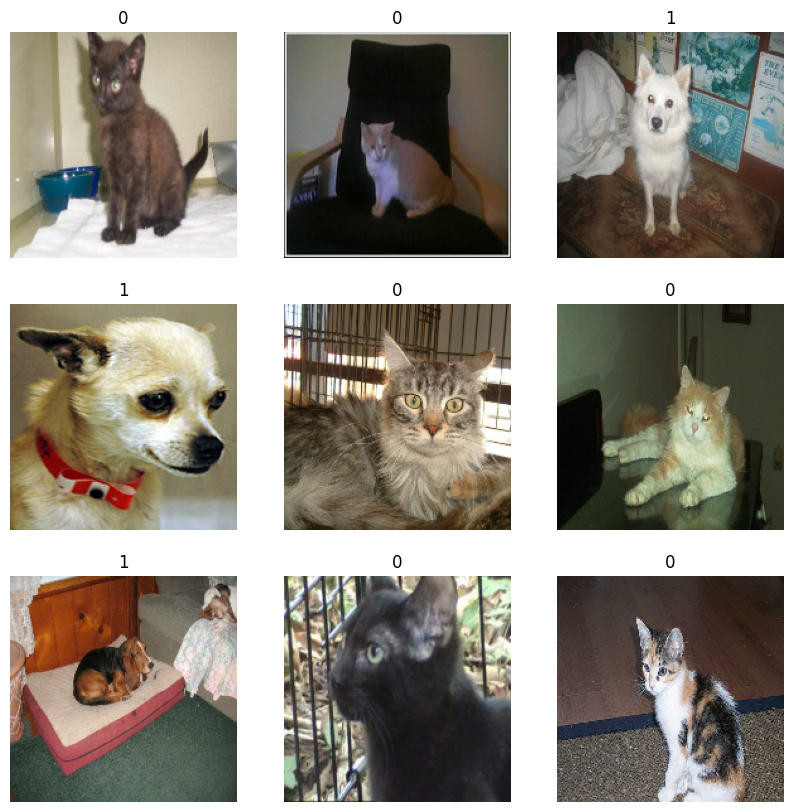

In [21]:


plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

In [22]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
    ]
)

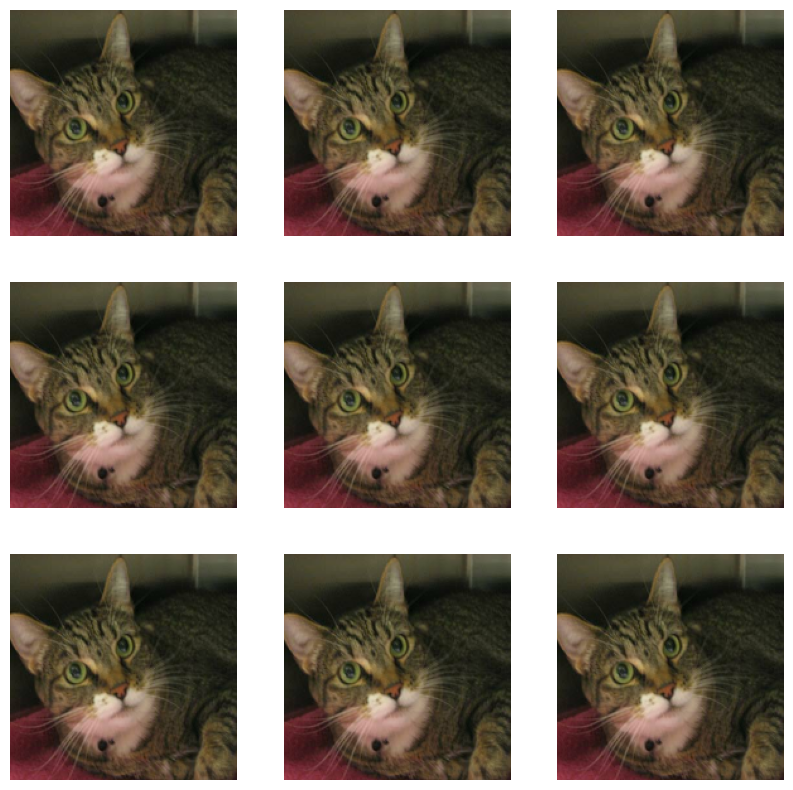

In [23]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [24]:
# Apply `data_augmentation` to the training images.
train_ds = train_ds.map(
    lambda img, label: (data_augmentation(img), label),
    num_parallel_calls=tf.data.AUTOTUNE,
)
# Prefetching samples in GPU memory helps maximize GPU utilization.
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)

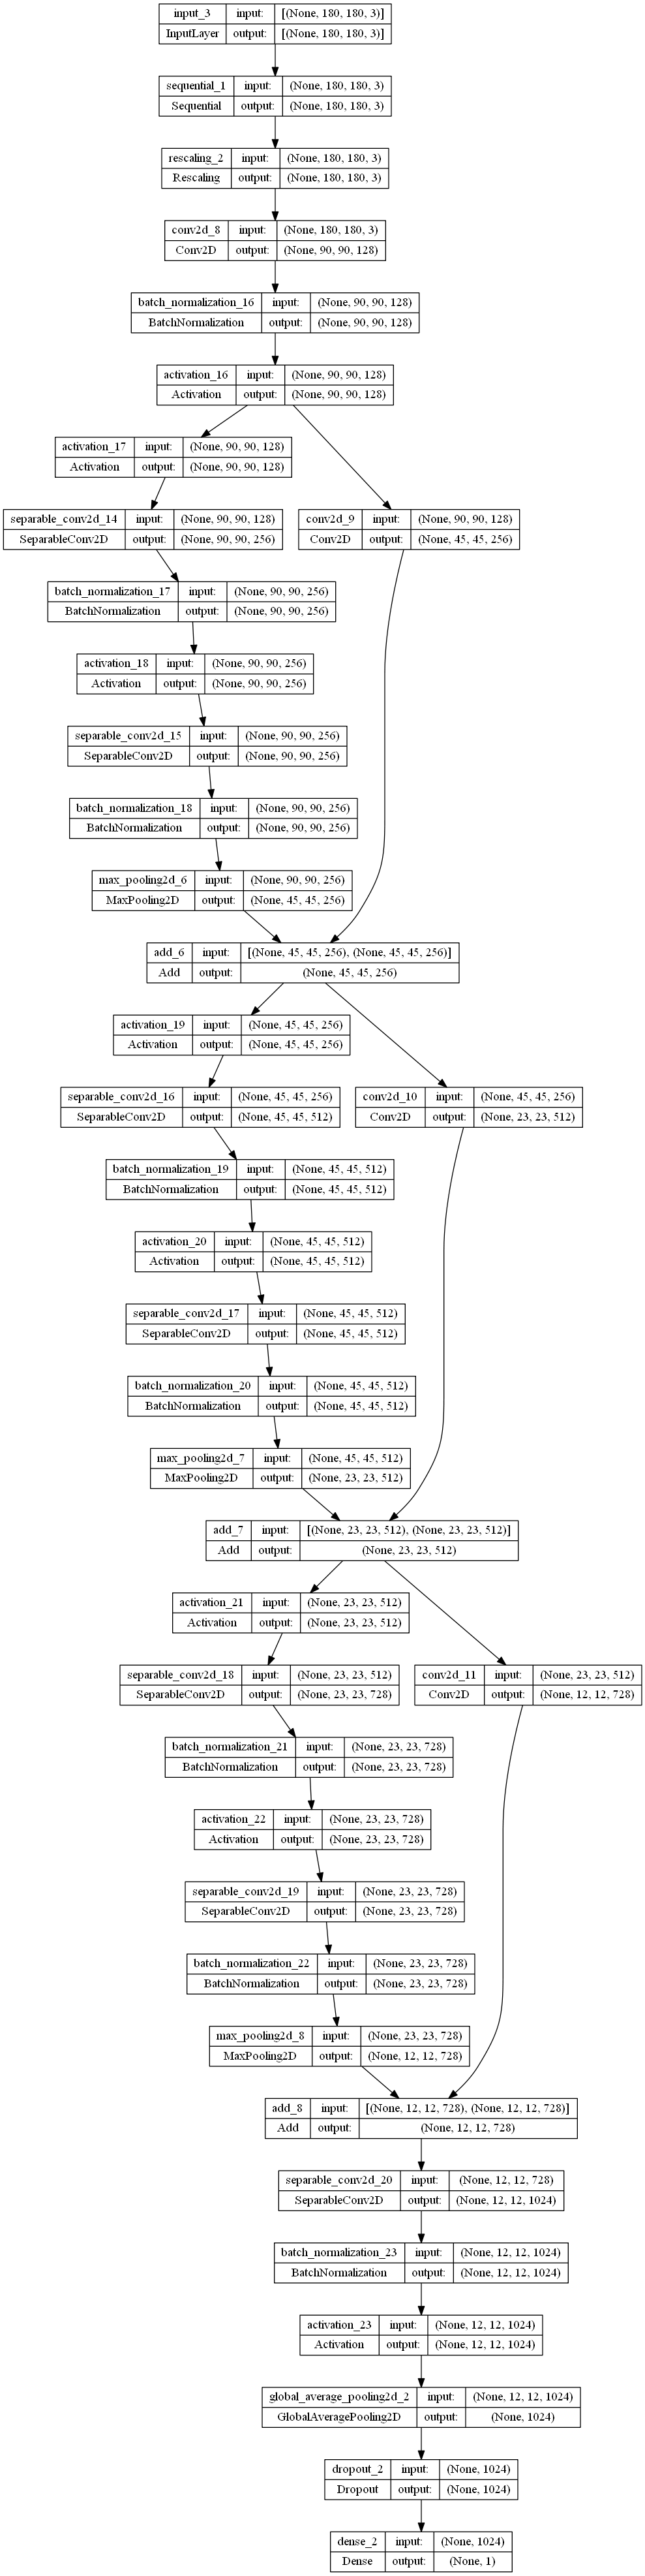

In [25]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)

    # Entry block
    x = data_augmentation(inputs)
    x = layers.Rescaling(1.0 / 255)(x)
    x = layers.Conv2D(128, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=2)
keras.utils.plot_model(model, show_shapes=True)

In [26]:
epochs = 25

callbacks = [
    keras.callbacks.ModelCheckpoint("dogs_cats_chkp\\save_at_{epoch}.keras"),
]
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=val_ds,
)

Epoch 1/25
586/586 [==============================] - 173s 292ms/step - loss: 0.6145 - accuracy: 0.6683 - val_loss: 0.7840 - val_accuracy: 0.4977
Epoch 2/25
586/586 [==============================] - 171s 291ms/step - loss: 0.5026 - accuracy: 0.7591 - val_loss: 0.4826 - val_accuracy: 0.7788
Epoch 3/25
586/586 [==============================] - 171s 292ms/step - loss: 0.4171 - accuracy: 0.8126 - val_loss: 0.4818 - val_accuracy: 0.7822
Epoch 4/25
586/586 [==============================] - 171s 291ms/step - loss: 0.3614 - accuracy: 0.8429 - val_loss: 0.3171 - val_accuracy: 0.8610
Epoch 5/25
586/586 [==============================] - 171s 291ms/step - loss: 0.3166 - accuracy: 0.8656 - val_loss: 0.3391 - val_accuracy: 0.8452
Epoch 6/25
586/586 [==============================] - 170s 291ms/step - loss: 0.2885 - accuracy: 0.8757 - val_loss: 0.2758 - val_accuracy: 0.8873
Epoch 7/25
586/586 [==============================] - 170s 291ms/step - loss: 0.2728 - accuracy: 0.8846 - val_loss: 0.2746 -

### Stanford Dog DATASET ON THE PREVIOUS MODEL ARCHITECTURE

In [56]:

num_skipped = 0
for subdir, dirs, files in os.walk("images"):
    for folder in dirs:
        folder_path = os.path.join("images", folder)
        for fname in os.listdir(folder_path):
            fpath = os.path.join(folder_path, fname)
            try:
                fobj = open(fpath, "rb")
                is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
            finally:
                fobj.close()

            if not is_jfif:
                num_skipped += 1
                # Delete corrupted image
                os.remove(fpath)

print("Deleted %d images" % num_skipped)

Deleted 17 images
Deleted 0 images


In [57]:
image_size = (180, 180)
batch_size = 32

train_stanford_dogs_ds, val_Stanford_dogs_ds = tf.keras.utils.image_dataset_from_directory(
    directory="images",
    validation_split=0.2,
    subset="both",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size
)


Found 20563 files belonging to 120 classes.
Using 16451 files for training.
Using 4112 files for validation.


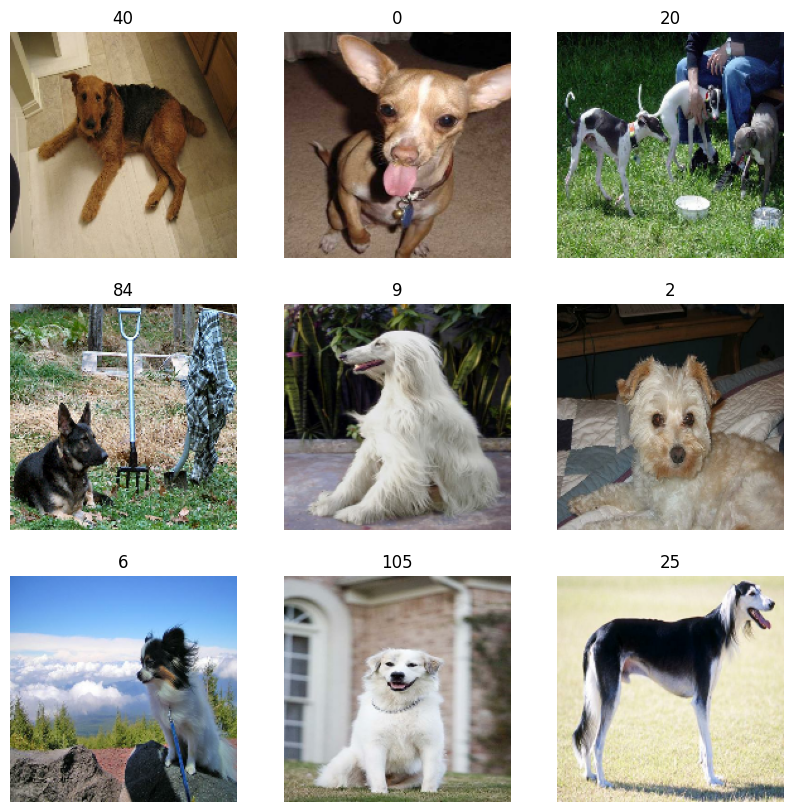

In [58]:
plt.figure(figsize=(10, 10))
for images, labels in train_stanford_dogs_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

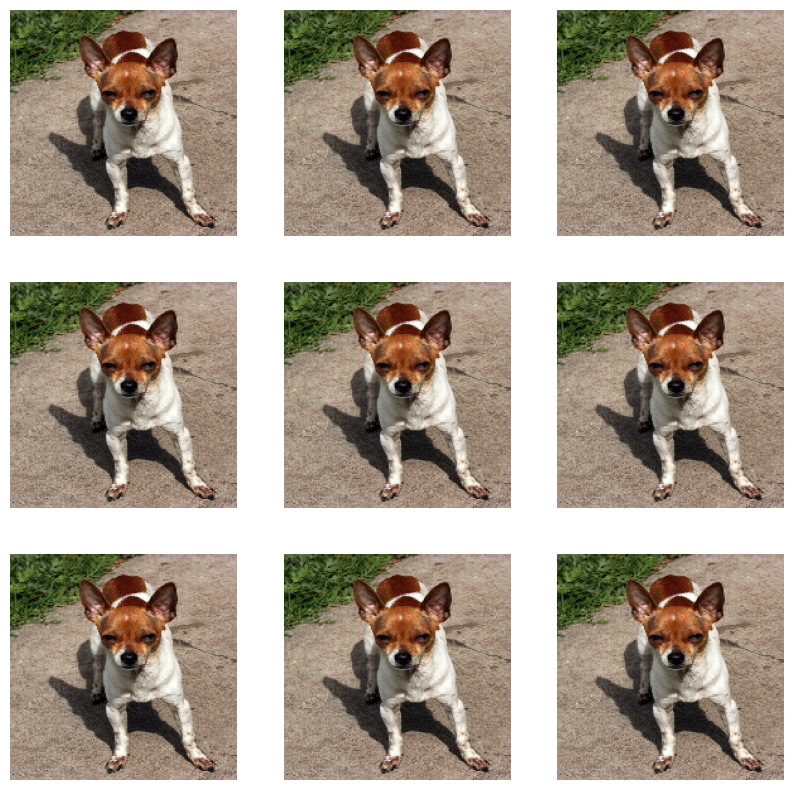

In [59]:
plt.figure(figsize=(10, 10))
for images, _ in train_stanford_dogs_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [60]:
# Apply `data_augmentation` to the training images.
train_stanford_dogs_ds = train_stanford_dogs_ds.map(
    lambda img, label: (data_augmentation(img), label),
    num_parallel_calls=tf.data.AUTOTUNE,
)
# Prefetching samples in GPU memory helps maximize GPU utilization.
train_stanford_dogs_ds = train_stanford_dogs_ds.prefetch(tf.data.AUTOTUNE)
val_Stanford_dogs_ds = val_Stanford_dogs_ds.prefetch(tf.data.AUTOTUNE)

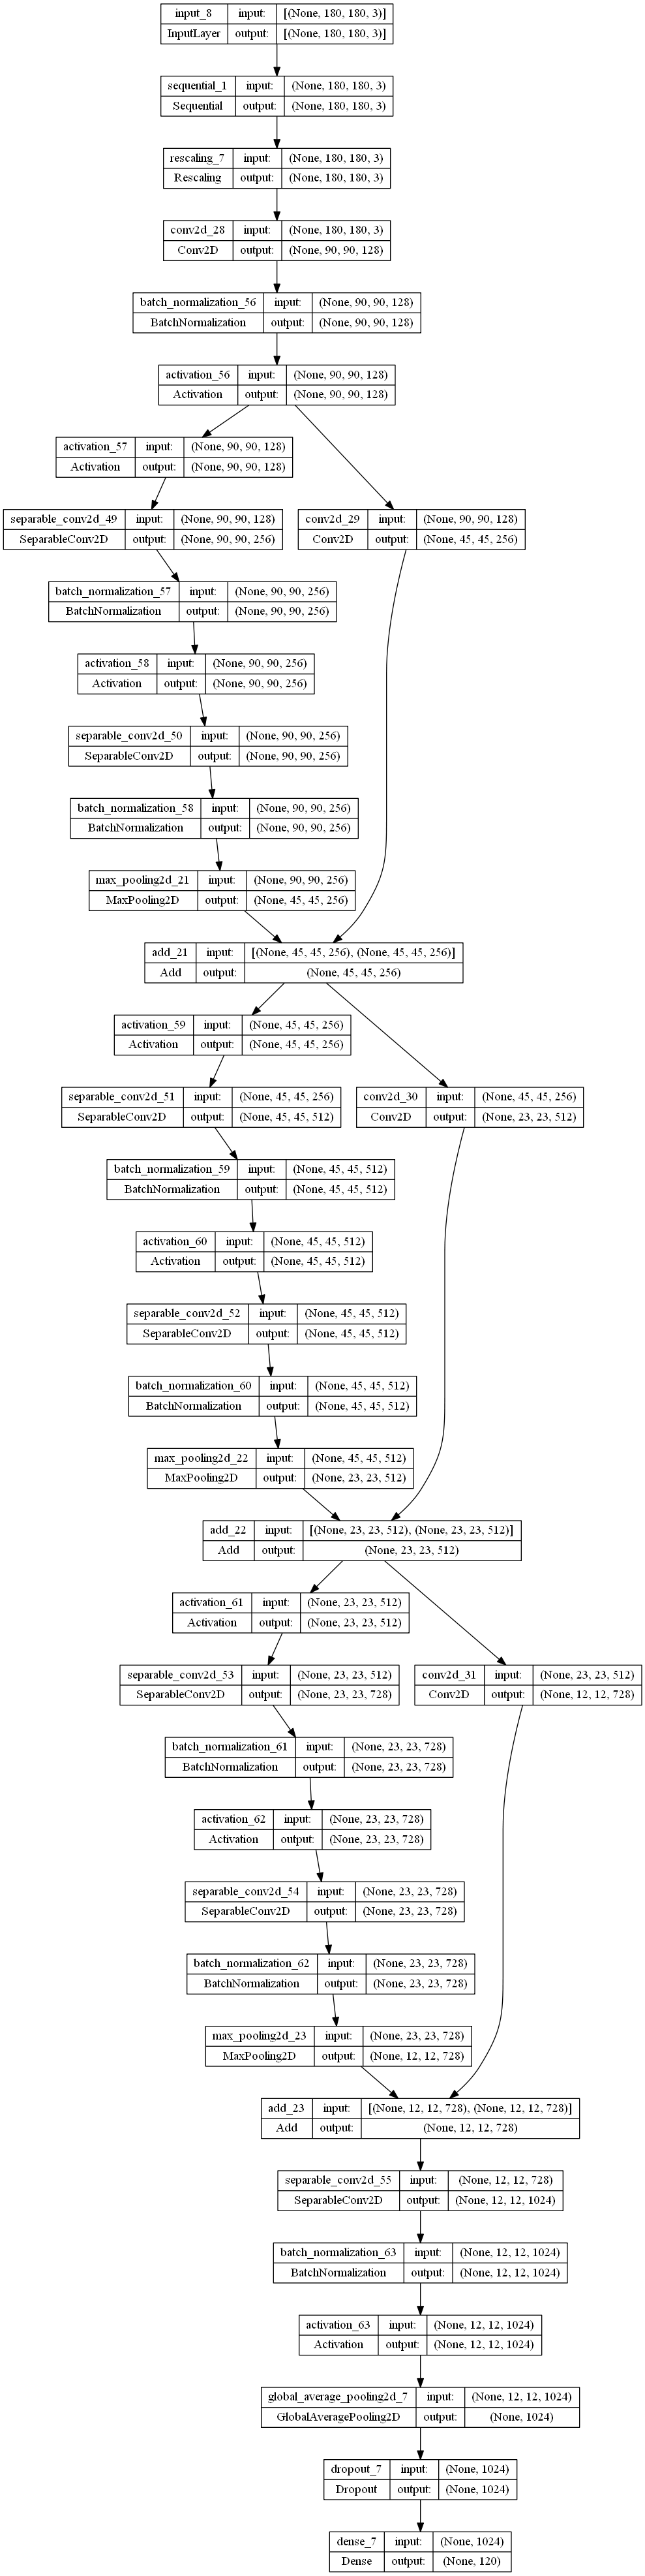

In [63]:
stanford_dogs = make_model(input_shape=image_size + (3,), num_classes=120)
keras.utils.plot_model(stanford_dogs, show_shapes=True)

In [64]:
epochs = 25

callbacks = [
    keras.callbacks.ModelCheckpoint("standford_dogs_chkp\\save_at_{epoch}.keras"),
]
stanford_dogs.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    loss=keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)
stanford_dogs.fit(
    train_stanford_dogs_ds,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=val_Stanford_dogs_ds
)

stanford_dogs.save("stanford_dogs_saved_model\\sd_CNN")
stanford_dogs.save_weights("stanford_dogs_saved_weights\\weights")

515/515 [==============================] - 155s 297ms/step - loss: 4.7842 - accuracy: 0.0212 - val_loss: 4.8531 - val_accuracy: 0.0122
Epoch 2/25
515/515 [==============================] - 151s 293ms/step - loss: 4.5483 - accuracy: 0.0345 - val_loss: 4.4567 - val_accuracy: 0.0508
Epoch 3/25
515/515 [==============================] - 151s 293ms/step - loss: 4.3618 - accuracy: 0.0528 - val_loss: 4.9957 - val_accuracy: 0.0336
Epoch 4/25
515/515 [==============================] - 151s 293ms/step - loss: 4.1887 - accuracy: 0.0712 - val_loss: 4.3384 - val_accuracy: 0.0625
Epoch 5/25
515/515 [==============================] - 151s 293ms/step - loss: 4.0064 - accuracy: 0.0880 - val_loss: 4.2094 - val_accuracy: 0.0759
Epoch 6/25
515/515 [==============================] - 151s 294ms/step - loss: 3.8426 - accuracy: 0.1153 - val_loss: 4.2495 - val_accuracy: 0.0768
Epoch 7/25
515/515 [==============================] - 151s 293ms/step - loss: 3.6903 - accuracy: 0.1318 - val_loss: 4.2070 - val_accura

INFO:tensorflow:Assets written to: stanford_dogs_saved_model\sd_CNN\assets


INFO:tensorflow:Assets written to: stanford_dogs_saved_model\sd_CNN\assets


Epoch 1/25


515/515 [==============================] - 154s 296ms/step - loss: 4.7876 - accuracy: 0.0197 - val_loss: 4.8159 - val_accuracy: 0.0122
Epoch 2/25
515/515 [==============================] - 152s 295ms/step - loss: 4.5448 - accuracy: 0.0360 - val_loss: 4.4767 - val_accuracy: 0.0447
Epoch 3/25
515/515 [==============================] - 152s 295ms/step - loss: 4.3519 - accuracy: 0.0562 - val_loss: 4.3408 - val_accuracy: 0.0620
Epoch 4/25
515/515 [==============================] - 152s 295ms/step - loss: 4.1639 - accuracy: 0.0739 - val_loss: 4.2112 - val_accuracy: 0.0676
Epoch 5/25
515/515 [==============================] - 152s 296ms/step - loss: 3.9833 - accuracy: 0.0950 - val_loss: 4.3480 - val_accuracy: 0.0642
Epoch 6/25
515/515 [==============================] - 152s 295ms/step - loss: 3.8237 - accuracy: 0.1153 - val_loss: 4.4320 - val_accuracy: 0.0713
Epoch 7/25
515/515 [==============================] - 152s 295ms/step - loss: 3.6713 - accuracy: 0.1384 - val_loss: 3.9934 - val_accura

INFO:tensorflow:Assets written to: stanford_dogs_saved_model\sd_CNN\assets


INFO:tensorflow:Assets written to: stanford_dogs_saved_model\sd_CNN\assets


 ## EXPERIMENT 2: TRANSFER MODEL FROM STANFORD DOGS DATASET TO TRAIN NEW MODEL FOR CAT AND DOGS DATASET

### EXPERIMENT 2 USING THE WEIGHTS OF THE SAVED MODEL ON A NEW MODEL AND FREEZING THE WEIGHTS OF ALL BUT THE OUTPUT LAYER OR THE UNCHANGED LAYERS

In [65]:
base_model = make_model(input_shape=image_size + (3,), num_classes=2)
saved_model = keras.models.load_model("stanford_dogs_saved_model/sd_CNN")
for i in range(len(base_model.layers)):
    base_model_layer = base_model.get_layer(index=i)
    saved_model_layer = saved_model.get_layer(index=i)
    print(base_model_layer)
    print(saved_model_layer)
    print("Base Layer: ", base_model_layer)
    print("Base number of Weights:", len(base_model_layer.weights))
    print("Saved number of Weights:", len(saved_model_layer.weights))
    print("Base number of Trainable Weights:", len(base_model_layer.trainable_weights))
    print("Base number of Non-Trainable Weights:", len(base_model_layer.non_trainable_weights))
    if base_model_layer.get_input_shape_at == saved_model_layer.get_input_shape_at:
        base_model_layer.set_weights(saved_model_layer.get_weights())
        base_model_layer.trainable = False


epochs = 50

callbacks = [
    keras.callbacks.ModelCheckpoint("cats_dogs_chkp\\save_at_{epoch}.keras"),
]
base_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    loss=keras.losses.BinaryCrossentropy(),
    metrics=['accuracy'],
)
base_model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=val_ds
)

base_model.save("cats_dogs_saved_model\\cd_CNN")
base_model.save_weights("cats_dogs_saved_weights\\weights")

Base Layer:  <keras.engine.input_layer.InputLayer object at 0x0000029DA6CEB280>
Base number of Weights: 0
Saved number of Weights: 0
Base number of Trainable Weights: 0
Base number of Non-Trainable Weights: 0
Base Layer:  <keras.engine.sequential.Sequential object at 0x0000029BC9A47700>
Base number of Weights: 0
Saved number of Weights: 0
Base number of Trainable Weights: 0
Base number of Non-Trainable Weights: 0
Base Layer:  <keras.layers.preprocessing.image_preprocessing.Rescaling object at 0x0000029D98F09930>
Base number of Weights: 0
Saved number of Weights: 0
Base number of Trainable Weights: 0
Base number of Non-Trainable Weights: 0
Base Layer:  <keras.layers.convolutional.conv2d.Conv2D object at 0x0000029D98F09F90>
Base number of Weights: 2
Saved number of Weights: 2
Base number of Trainable Weights: 2
Base number of Non-Trainable Weights: 0
Base Layer:  <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x0000029D98F08C70>
Base number of Weights: 4
Sav

586/586 [==============================] - 174s 293ms/step - loss: 0.6217 - accuracy: 0.6588 - val_loss: 0.9229 - val_accuracy: 0.4957
Epoch 2/50
586/586 [==============================] - 173s 294ms/step - loss: 0.5157 - accuracy: 0.7501 - val_loss: 0.4788 - val_accuracy: 0.7852
Epoch 3/50
586/586 [==============================] - 174s 297ms/step - loss: 0.4326 - accuracy: 0.8023 - val_loss: 0.3782 - val_accuracy: 0.8328
Epoch 4/50
586/586 [==============================] - 173s 296ms/step - loss: 0.3668 - accuracy: 0.8372 - val_loss: 0.3086 - val_accuracy: 0.8698
Epoch 5/50
586/586 [==============================] - 174s 297ms/step - loss: 0.3157 - accuracy: 0.8675 - val_loss: 0.5606 - val_accuracy: 0.7859
Epoch 6/50
586/586 [==============================] - 172s 293ms/step - loss: 0.2821 - accuracy: 0.8805 - val_loss: 1.1130 - val_accuracy: 0.6759
Epoch 7/50
586/586 [==============================] - 174s 297ms/step - loss: 0.2547 - accuracy: 0.8910 - val_loss: 0.3010 - val_accura

INFO:tensorflow:Assets written to: cats_dogs_saved_model\cd_CNN\assets


INFO:tensorflow:Assets written to: cats_dogs_saved_model\cd_CNN\assets


### EXPERIMENT 2 NO FROZEN WEIGHTS NEW MODEL USING THE LOADED MODEL

In [66]:
loaded_model = keras.models.load_model("stanford_dogs_saved_model/sd_CNN")
#print(loaded_model.summary())

inputs = loaded_model.inputs
x = loaded_model.layers[-2].output
new_outputs = layers.Dense(1, activation="sigmoid")(x)

new_model = keras.Model(loaded_model.inputs, new_outputs)
print(new_model.summary())
epochs = 50

callbacks = [
    keras.callbacks.ModelCheckpoint("cats_dogs_loaded_chkp\\save_at_{epoch}.keras"),
]
new_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    loss=keras.losses.BinaryCrossentropy(),
    metrics=['accuracy'],
)
new_model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=val_ds
)

new_model.save("cats_dogs_loaded_model\\cd_CNN")
new_model.save_weights("cats_dogs_loaded_weights\\weights")

Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 180, 180, 3  0           []                               
                                )]                                                                
                                                                                                  
 sequential_1 (Sequential)      (None, 180, 180, 3)  0           ['input_8[0][0]']                
                                                                                                  
 rescaling_7 (Rescaling)        (None, 180, 180, 3)  0           ['sequential_1[0][0]']           
                                                                                                  
 conv2d_28 (Conv2D)             (None, 90, 90, 128)  3584        ['rescaling_7[0][0]']      

586/586 [==============================] - 172s 289ms/step - loss: 0.3722 - accuracy: 0.8326 - val_loss: 0.5781 - val_accuracy: 0.7383
Epoch 2/50
586/586 [==============================] - 169s 289ms/step - loss: 0.2519 - accuracy: 0.8941 - val_loss: 0.2771 - val_accuracy: 0.8768
Epoch 3/50
586/586 [==============================] - 169s 288ms/step - loss: 0.2038 - accuracy: 0.9141 - val_loss: 0.6936 - val_accuracy: 0.7664
Epoch 4/50
586/586 [==============================] - 169s 288ms/step - loss: 0.1897 - accuracy: 0.9217 - val_loss: 0.1715 - val_accuracy: 0.9347
Epoch 5/50
586/586 [==============================] - 169s 288ms/step - loss: 0.1636 - accuracy: 0.9324 - val_loss: 0.2231 - val_accuracy: 0.9112
Epoch 6/50
586/586 [==============================] - 169s 288ms/step - loss: 0.1514 - accuracy: 0.9394 - val_loss: 0.5178 - val_accuracy: 0.8036
Epoch 7/50
586/586 [==============================] - 169s 288ms/step - loss: 0.1379 - accuracy: 0.9463 - val_loss: 0.2076 - val_accura

INFO:tensorflow:Assets written to: cats_dogs_loaded_model\cd_CNN\assets


INFO:tensorflow:Assets written to: cats_dogs_loaded_model\cd_CNN\assets


### EXPERIMENT 3: LOAD SAVED MODEL FROM STANFORD DOGS AND REPLACE OUTPUT LAYER AND THE FIRST TWO CONVOLUTIONAL LAYERS

In [67]:
base_model = make_model(input_shape=image_size + (3,), num_classes=2)
saved_model = keras.models.load_model("stanford_dogs_saved_model/sd_CNN")
for i in range(len(base_model.layers)):
    base_model_layer = base_model.get_layer(index=i)
    saved_model_layer = saved_model.get_layer(index=i)
    print(base_model_layer, "iteration ", i)
    print(saved_model_layer)
    print("Base Layer: ", base_model_layer)
    print("Base number of Weights:", len(base_model_layer.weights))
    print("Saved number of Weights:", len(saved_model_layer.weights))
    print("Base number of Trainable Weights:", len(base_model_layer.trainable_weights))
    print("Base number of Non-Trainable Weights:", len(base_model_layer.non_trainable_weights))
    print(saved_model_layer.get_input_shape_at, base_model_layer.get_input_shape_at)
    if base_model_layer.get_input_shape_at == saved_model_layer.get_input_shape_at:
        if i != 3 or i != 7:
            base_model_layer.set_weights(saved_model_layer.get_weights())
            base_model_layer.trainable = False


epochs = 50

callbacks = [
    keras.callbacks.ModelCheckpoint("cats_dogs_ex3_chkp\\save_at_{epoch}.keras"),
]
base_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    loss=keras.losses.BinaryCrossentropy(),
    metrics=['accuracy'],
)
base_model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=val_ds
)

base_model.save("cats_dogs_ex3_saved_model\\cd_CNN")
base_model.save_weights("cats_dogs_ex3_saved_weights\\weights")

<keras.engine.input_layer.InputLayer object at 0x0000029DA539A6B0> iteration  0
Base Layer:  <keras.engine.input_layer.InputLayer object at 0x0000029DA539A6B0>
Base number of Weights: 0
Saved number of Weights: 0
Base number of Trainable Weights: 0
Base number of Non-Trainable Weights: 0
<bound method Layer.get_input_shape_at of <keras.engine.input_layer.InputLayer object at 0x0000029E6A62F8E0>> <bound method Layer.get_input_shape_at of <keras.engine.input_layer.InputLayer object at 0x0000029DA539A6B0>>
<keras.engine.sequential.Sequential object at 0x0000029BC9A47700> iteration  1
Base Layer:  <keras.engine.sequential.Sequential object at 0x0000029BC9A47700>
Base number of Weights: 0
Saved number of Weights: 0
Base number of Trainable Weights: 0
Base number of Non-Trainable Weights: 0
<bound method Layer.get_input_shape_at of <keras.engine.sequential.Sequential object at 0x0000029DAC590040>> <bound method Layer.get_input_shape_at of <keras.engine.sequential.Sequential object at 0x00000

586/586 [==============================] - 171s 289ms/step - loss: 0.6139 - accuracy: 0.6661 - val_loss: 0.9784 - val_accuracy: 0.4957
Epoch 2/50
586/586 [==============================] - 169s 288ms/step - loss: 0.5017 - accuracy: 0.7556 - val_loss: 0.4211 - val_accuracy: 0.8098
Epoch 3/50
586/586 [==============================] - 169s 289ms/step - loss: 0.4173 - accuracy: 0.8100 - val_loss: 0.3634 - val_accuracy: 0.8439
Epoch 4/50
586/586 [==============================] - 169s 288ms/step - loss: 0.3589 - accuracy: 0.8450 - val_loss: 0.3949 - val_accuracy: 0.8205
Epoch 5/50
586/586 [==============================] - 170s 289ms/step - loss: 0.3156 - accuracy: 0.8679 - val_loss: 0.4550 - val_accuracy: 0.7925
Epoch 6/50
586/586 [==============================] - 170s 290ms/step - loss: 0.2761 - accuracy: 0.8827 - val_loss: 0.2986 - val_accuracy: 0.8783
Epoch 7/50
586/586 [==============================] - 169s 288ms/step - loss: 0.2486 - accuracy: 0.8949 - val_loss: 0.5752 - val_accura

INFO:tensorflow:Assets written to: cats_dogs_ex3_saved_model\cd_CNN\assets


INFO:tensorflow:Assets written to: cats_dogs_ex3_saved_model\cd_CNN\assets


In [68]:
loaded_model = keras.models.load_model("stanford_dogs_saved_model/sd_CNN")
#print(loaded_model.summary())

inputs = loaded_model.inputs
x = loaded_model.layers[2].output
x = layers.Conv2D(128, 3, strides=2, padding="same")(x)
x = loaded_model.layers[6].output
x = layers.SeparableConv2D(256, 3, padding="same")(x)
x = loaded_model.layers[-2].output
new_outputs = layers.Dense(1, activation="sigmoid")(x)

new_model = keras.Model(loaded_model.inputs, new_outputs)
print(new_model.summary())
epochs = 50

callbacks = [
    keras.callbacks.ModelCheckpoint("cats_dogs_loaded_chkp\\save_at_{epoch}.keras"),
]
new_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    loss=keras.losses.BinaryCrossentropy(),
    metrics=['accuracy'],
)
new_model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=val_ds
)

new_model.save("cats_dogs_ex3_loaded_model\\cd_CNN")
new_model.save_weights("cats_dogs_ex3_loaded_weights\\weights")

Model: "model_11"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 180, 180, 3  0           []                               
                                )]                                                                
                                                                                                  
 sequential_1 (Sequential)      (None, 180, 180, 3)  0           ['input_8[0][0]']                
                                                                                                  
 rescaling_7 (Rescaling)        (None, 180, 180, 3)  0           ['sequential_1[0][0]']           
                                                                                                  
 conv2d_28 (Conv2D)             (None, 90, 90, 128)  3584        ['rescaling_7[0][0]']     

586/586 [==============================] - 174s 293ms/step - loss: 0.3753 - accuracy: 0.8327 - val_loss: 0.2587 - val_accuracy: 0.8913
Epoch 2/50
586/586 [==============================] - 171s 292ms/step - loss: 0.2544 - accuracy: 0.8939 - val_loss: 0.2428 - val_accuracy: 0.9061
Epoch 3/50
586/586 [==============================] - 172s 293ms/step - loss: 0.2087 - accuracy: 0.9134 - val_loss: 0.2557 - val_accuracy: 0.8933
Epoch 4/50
586/586 [==============================] - 172s 293ms/step - loss: 0.1820 - accuracy: 0.9266 - val_loss: 0.2851 - val_accuracy: 0.8760
Epoch 5/50
586/586 [==============================] - 171s 292ms/step - loss: 0.1666 - accuracy: 0.9338 - val_loss: 0.1879 - val_accuracy: 0.9274
Epoch 6/50
586/586 [==============================] - 173s 294ms/step - loss: 0.1544 - accuracy: 0.9369 - val_loss: 0.3171 - val_accuracy: 0.8661
Epoch 7/50
586/586 [==============================] - 172s 293ms/step - loss: 0.1377 - accuracy: 0.9455 - val_loss: 0.3174 - val_accura

INFO:tensorflow:Assets written to: cats_dogs_ex3_loaded_model\cd_CNN\assets


INFO:tensorflow:Assets written to: cats_dogs_ex3_loaded_model\cd_CNN\assets


## EXPERIMENT 4:LOAD SAVED MODEL FROM STANFORD DOGS AND REPLACE OUTPUT LAYER AND THE LAST TWO CONVOLUTIONAL LAYERS

In [70]:
loaded_model = keras.models.load_model("stanford_dogs_saved_model/sd_CNN")
#print(loaded_model.summary())

inputs = loaded_model.inputs
x = loaded_model.layers[-11].output
x = x = layers.SeparableConv2D(728, 3, padding="same")(x)
x = loaded_model.layers[-7].output
x = layers.SeparableConv2D(1024, 3, padding="same")(x)
x = loaded_model.layers[-2].output
new_outputs = layers.Dense(1, activation="sigmoid")(x)

new_model = keras.Model(loaded_model.inputs, new_outputs)
print(new_model.summary())
epochs = 50

callbacks = [
    keras.callbacks.ModelCheckpoint("cats_dogs_loaded_chkp\\save_at_{epoch}.keras"),
]
new_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    loss=keras.losses.BinaryCrossentropy(),
    metrics=['accuracy'],
)
new_model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=val_ds
)

new_model.save("cats_dogs_ex4_loaded_model\\cd_CNN")
new_model.save_weights("cats_dogs_ex4_loaded_weights\\weights")

Model: "model_13"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 180, 180, 3  0           []                               
                                )]                                                                
                                                                                                  
 sequential_1 (Sequential)      (None, 180, 180, 3)  0           ['input_8[0][0]']                
                                                                                                  
 rescaling_7 (Rescaling)        (None, 180, 180, 3)  0           ['sequential_1[0][0]']           
                                                                                                  
 conv2d_28 (Conv2D)             (None, 90, 90, 128)  3584        ['rescaling_7[0][0]']     

586/586 [==============================] - 174s 294ms/step - loss: 0.3683 - accuracy: 0.8343 - val_loss: 0.2693 - val_accuracy: 0.8883
Epoch 2/50
586/586 [==============================] - 171s 292ms/step - loss: 0.2483 - accuracy: 0.8962 - val_loss: 0.6396 - val_accuracy: 0.7667
Epoch 3/50
586/586 [==============================] - 172s 294ms/step - loss: 0.2107 - accuracy: 0.9130 - val_loss: 0.3523 - val_accuracy: 0.8523
Epoch 4/50
586/586 [==============================] - 172s 293ms/step - loss: 0.1824 - accuracy: 0.9255 - val_loss: 0.1793 - val_accuracy: 0.9310
Epoch 5/50
586/586 [==============================] - 172s 293ms/step - loss: 0.1606 - accuracy: 0.9358 - val_loss: 0.2431 - val_accuracy: 0.8952
Epoch 6/50
586/586 [==============================] - 172s 293ms/step - loss: 0.1529 - accuracy: 0.9367 - val_loss: 0.1845 - val_accuracy: 0.9308
Epoch 7/50
586/586 [==============================] - 172s 293ms/step - loss: 0.1321 - accuracy: 0.9479 - val_loss: 0.2862 - val_accura

INFO:tensorflow:Assets written to: cats_dogs_ex4_loaded_model\cd_CNN\assets


INFO:tensorflow:Assets written to: cats_dogs_ex4_loaded_model\cd_CNN\assets


In [71]:
base_model = make_model(input_shape=image_size + (3,), num_classes=2)
saved_model = keras.models.load_model("stanford_dogs_saved_model/sd_CNN")
for i in range(len(base_model.layers)):
    base_model_layer = base_model.get_layer(index=i)
    saved_model_layer = saved_model.get_layer(index=i)
    print(base_model_layer, "iteration ", i)
    print(saved_model_layer)
    print("Base Layer: ", base_model_layer)
    print("Base number of Weights:", len(base_model_layer.weights))
    print("Saved number of Weights:", len(saved_model_layer.weights))
    print("Base number of Trainable Weights:", len(base_model_layer.trainable_weights))
    print("Base number of Non-Trainable Weights:", len(base_model_layer.non_trainable_weights))
    print(saved_model_layer.get_input_shape_at, base_model_layer.get_input_shape_at)
    if base_model_layer.get_input_shape_at == saved_model_layer.get_input_shape_at:
        if i != 28 or i != 33:
            base_model_layer.set_weights(saved_model_layer.get_weights())
            base_model_layer.trainable = False


epochs = 50

callbacks = [
    keras.callbacks.ModelCheckpoint("cats_dogs_ex3_chkp\\save_at_{epoch}.keras"),
]
base_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    loss=keras.losses.BinaryCrossentropy(),
    metrics=['accuracy'],
)
base_model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=val_ds
)

base_model.save("cats_dogs_ex4_saved_model\\cd_CNN")
base_model.save_weights("cats_dogs_ex4_saved_weights\\weights")

<keras.engine.input_layer.InputLayer object at 0x0000029DBE347FA0> iteration  0
Base Layer:  <keras.engine.input_layer.InputLayer object at 0x0000029DBE347FA0>
Base number of Weights: 0
Saved number of Weights: 0
Base number of Trainable Weights: 0
Base number of Non-Trainable Weights: 0
<bound method Layer.get_input_shape_at of <keras.engine.input_layer.InputLayer object at 0x0000029EC2E8A050>> <bound method Layer.get_input_shape_at of <keras.engine.input_layer.InputLayer object at 0x0000029DBE347FA0>>
<keras.engine.sequential.Sequential object at 0x0000029BC9A47700> iteration  1
Base Layer:  <keras.engine.sequential.Sequential object at 0x0000029BC9A47700>
Base number of Weights: 0
Saved number of Weights: 0
Base number of Trainable Weights: 0
Base number of Non-Trainable Weights: 0
<bound method Layer.get_input_shape_at of <keras.engine.sequential.Sequential object at 0x0000029EC2E8B550>> <bound method Layer.get_input_shape_at of <keras.engine.sequential.Sequential object at 0x00000

586/586 [==============================] - 173s 292ms/step - loss: 0.6124 - accuracy: 0.6638 - val_loss: 0.8240 - val_accuracy: 0.4959
Epoch 2/50
586/586 [==============================] - 171s 292ms/step - loss: 0.5091 - accuracy: 0.7496 - val_loss: 0.4605 - val_accuracy: 0.7940
Epoch 3/50
586/586 [==============================] - 171s 292ms/step - loss: 0.4291 - accuracy: 0.8034 - val_loss: 0.3645 - val_accuracy: 0.8386
Epoch 4/50
586/586 [==============================] - 172s 293ms/step - loss: 0.3628 - accuracy: 0.8416 - val_loss: 0.3328 - val_accuracy: 0.8570
Epoch 5/50
586/586 [==============================] - 172s 293ms/step - loss: 0.3126 - accuracy: 0.8682 - val_loss: 0.2579 - val_accuracy: 0.8937
Epoch 6/50
586/586 [==============================] - 172s 293ms/step - loss: 0.2789 - accuracy: 0.8818 - val_loss: 0.2435 - val_accuracy: 0.9014
Epoch 7/50
586/586 [==============================] - 172s 293ms/step - loss: 0.2504 - accuracy: 0.8958 - val_loss: 0.3402 - val_accura

INFO:tensorflow:Assets written to: cats_dogs_ex4_saved_model\cd_CNN\assets


INFO:tensorflow:Assets written to: cats_dogs_ex4_saved_model\cd_CNN\assets
